NOAA download data: Extract period of record for each station and variables of interest (water levels, flow) 
This option allows you to use two or more stations.

To plot the water levels from multiple stations on the same hydrograph.
This way, you can compare the water levels from different stations over the same period.

In [1]:
#
import requests
import pandas as pd
import matplotlib.pyplot as plt

Data fetched successfully for station 8632200:
            date_time  water_level      s        f  q
0 2024-02-07 00:00:00        1.185  0.003  0,0,0,0  v
1 2024-02-07 00:06:00        1.169  0.003  0,0,0,0  v
2 2024-02-07 00:12:00        1.161  0.004  0,0,0,0  v
3 2024-02-07 00:18:00        1.148  0.004  0,0,0,0  v
4 2024-02-07 00:24:00        1.136  0.003  0,0,0,0  v
Data fetched successfully for station 8635750:
            date_time  water_level      s        f  q
0 2024-02-07 00:00:00        0.720  0.005  0,0,0,0  v
1 2024-02-07 00:06:00        0.727  0.005  0,0,0,0  v
2 2024-02-07 00:12:00        0.737  0.004  0,0,0,0  v
3 2024-02-07 00:18:00        0.744  0.004  0,0,0,0  v
4 2024-02-07 00:24:00        0.750  0.004  0,0,0,0  v
Hydrograph saved as hydrograph_multiple_stations_20240207_20240210.png


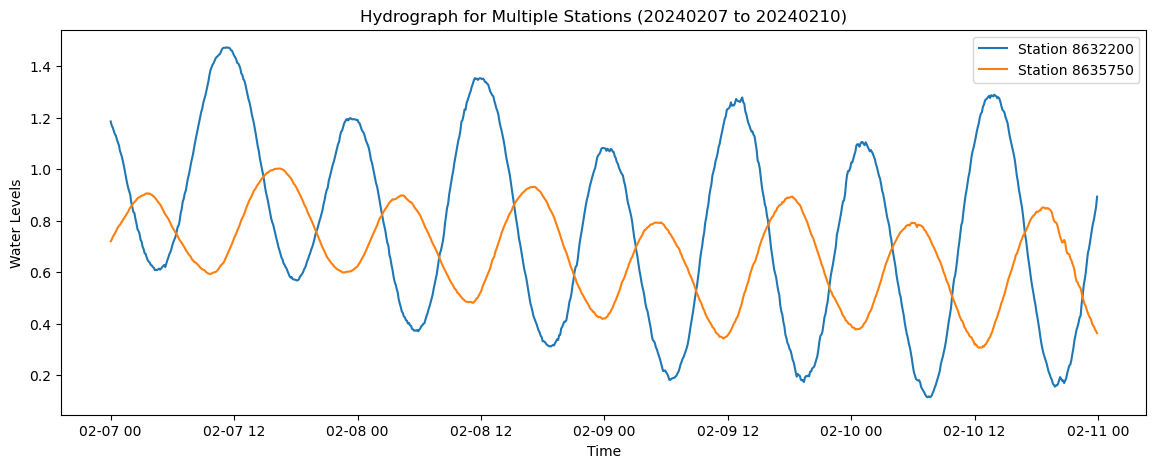

In [4]:
def get_water_levels(start_date, end_date, station_id, datum='MLLW', units='metric', time_zone='gmt', product='water_level', format='json'):
    """
    Fetch water levels from NOAA Tides and Currents API.

    Parameters:
    start_date (str): Start date in YYYYMMDD format.
    end_date (str): End date in YYYYMMDD format.
    station_id (str): NOAA station ID.
    datum (str): Datum to use for water level data. Default is 'MLLW'.
    units (str): Units of measurement. Default is 'metric'.
    time_zone (str): Time zone. Default is 'gmt'.
    product (str): Data product to retrieve. Default is 'water_level'.
    format (str): Response format. Default is 'json'.

    Returns:
    pd.DataFrame: DataFrame containing date and water level data.
    """
    base_url = 'https://api.tidesandcurrents.noaa.gov/api/prod/datagetter'
    params = {
        'begin_date': start_date,
        'end_date': end_date,
        'station': station_id,
        'product': product,
        'datum': datum,
        'units': units,
        'time_zone': time_zone,
        'format': format
    }
    
    response = requests.get(base_url, params=params)
    
    if response.status_code != 200:
        raise Exception(f"Error fetching data: {response.status_code}, Details: {response.text}")
    
    data = response.json()
    
    if 'error' in data:
        raise Exception(f"Error in response: {data['error']['message']}")
    
    # Convert data to DataFrame
    df = pd.DataFrame(data['data'])
    df['t'] = pd.to_datetime(df['t'])  # Ensure that 't' includes both date and time
    df.rename(columns={'t': 'date_time', 'v': 'water_level'}, inplace=True)
    
    # Ensure water_level is numeric and handle errors
    df['water_level'] = pd.to_numeric(df['water_level'], errors='coerce')
    
    # Drop rows with missing or non-numeric water levels
    df = df.dropna(subset=['water_level'])
    
    return df

def plot_hydrograph(stations_data, start_date, end_date):
    """
    Plot a hydrograph with water level data from multiple stations.

    Parameters:
    stations_data (dict): A dictionary where keys are station IDs and values are DataFrames containing water level data.
    start_date (str): Start date in YYYYMMDD format.
    end_date (str): End date in YYYYMMDD format.
    """
    plt.figure(figsize=(14, 5))
    
    for station_id, water_levels in stations_data.items():
        plt.plot(water_levels['date_time'], water_levels['water_level'], label=f'Station {station_id}')
    
    plt.title(f'Hydrograph for Multiple Stations ({start_date} to {end_date})')
    plt.xlabel('Time')
    plt.ylabel('Water Levels')
    plt.legend()
    
    # Save the plot as a PNG image
    plot_file_name = f'hydrograph_multiple_stations_{start_date}_{end_date}.png'
    plt.savefig(plot_file_name)
    print(f"Hydrograph saved as {plot_file_name}")
    
    # Show the plot
    plt.show()

def main():
    # User inputs
    start_date = input("Enter start date (YYYYMMDD): ")
    end_date = input("Enter end date (YYYYMMDD): ")
    
    # Input for multiple station IDs, separated by commas
    station_ids = input("Enter NOAA station IDs separated by commas: ").split(',')

    # Validate input formats
    if not (len(start_date) == 8 and start_date.isdigit()):
        print("Invalid start date format. Please use YYYYMMDD.")
        return
    if not (len(end_date) == 8 and end_date.isdigit()):
        print("Invalid end date format. Please use YYYYMMDD.")
        return

    stations_data = {}

    for station_id in station_ids:
        station_id = station_id.strip()  # Clean up whitespace
        if not station_id.isdigit():
            print(f"Invalid station ID: {station_id}. Please use a valid numeric station ID.")
            continue
        
        # Fetch water levels for the current station ID
        try:
            water_levels = get_water_levels(start_date, end_date, station_id)
            print(f"Data fetched successfully for station {station_id}:")
            print(water_levels.head())
            
            stations_data[station_id] = water_levels
            
        except Exception as e:
            print(f"Error processing station {station_id}: {e}")
    
    # Plot hydrograph for all stations on the same graph
    if stations_data:
        plot_hydrograph(stations_data, start_date, end_date)
    else:
        print("No valid data available for plotting.")

if __name__ == "__main__":
    main()
